# **Classifying Figure-Ground Segregation Using Gamma-Oscillations in V1 with Machine-Learning.**

This project applies Machine Learning to explore the link between gamma oscillations in the primary visual cortex (V1) and figure-ground segregation in texture stimuli. Using RF, SVM, and XGBoost on V1 neural data, features like 'ContrastHeterogeneity' predict gamma synchronization in visual processing. The next code can be performed in any computer with the correct packages installed and setting small changes in the paths for the data extraction. 



## Importing the packages that are needed for the analysis. 

In [27]:
# Data manipulation.
import pandas as pd 
import numpy as np 

# Plots vizualization.
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning packages. 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier  

## Importing the data. 

In [28]:
# Set the pathway where you have saved the file with the data.
data = pd.read_csv('/Users/rodrigosanchez/Documents/ScientificProgramming/Experiment.csv')

# Data Cleaning. 
In this specific case the data cleaning is not needed due the dataset has a good structure and is complete, however here is some code that performs the data clean in case it is needed.

In [ ]:
# Missing values 
missing = data.isnull().sum()
print("Missing values in each column:\n", missing)
dataCleaned1 = data.dropna()

# Duplicates 
dupli = dataCleaned1.duplicated().sum()
print(f"Number of duplicate rows: {dupli}")
dataCleaned1 = dataCleaned1.drop_duplicates()

# Outliers 
def remove_outliers(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data   

dataCleaned1 = remove_outliers(dataCleaned1, ['ContrastHeterogeneity', 'GridCoarseness'])

# Check 
print(dataCleaned1.dtypes)

dataCleaned1['SubjectID'] = dataCleaned1['SubjectID'].astype(int)
dataCleaned1['SessionID'] = dataCleaned1['SessionID'].astype(int)
dataCleaned1['BlockID'] = dataCleaned1['BlockID'].astype(int)
    
# Save the data clenaed 
dataCleaned1.to_csv('/Users/rodrigosanchez/Documents/ScientificProgramming/Experiment.csv', index=False)

# Data visualization. 

**HeatMap**
Present how the accuray (taking the data from “Correct” feature) change through the “ContrastHeterogeneity” and “GridCoarseness” features. 


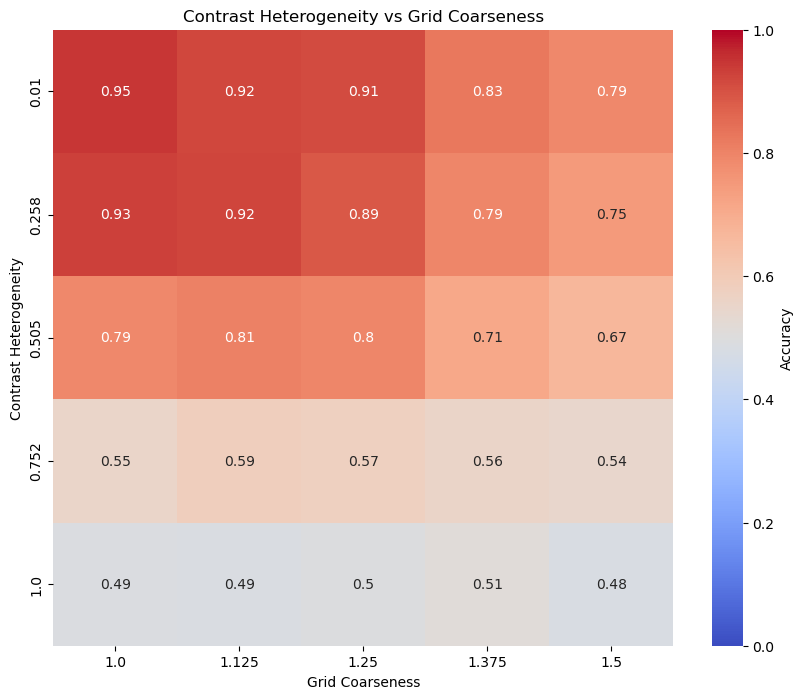

In [29]:
# Taking the two features and measuring the accuracy. 
accuracy_data = data.groupby(['ContrastHeterogeneity', 'GridCoarseness']).mean()['Correct'].unstack() 

# Plotting. 
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_data, cmap="coolwarm", vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'}, annot=True)
plt.title("Contrast Heterogeneity vs Grid Coarseness")
plt.xlabel("Grid Coarseness")
plt.ylabel("Contrast Heterogeneity")
plt.show()

**Bar plot**, presents the mean accuracy of the responses, using the feature of “Condition”. 
 

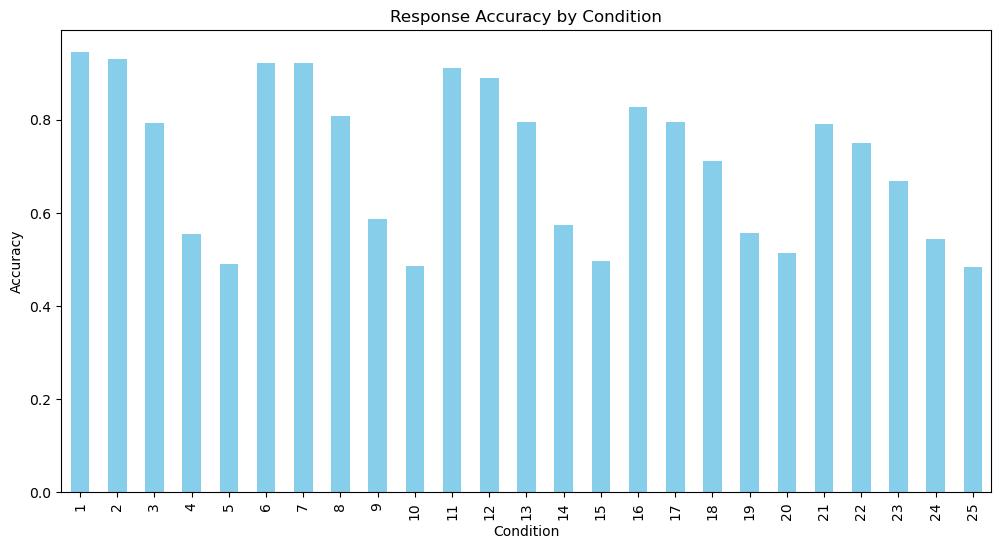

In [30]:
# Calculate the mean accuracy by the feature “Condition”. 
accuracy_by_condotion = data.groupby('Condition').mean()['Correct']

# Plotting. 
plt.figure(figsize=(12, 6))
accuracy_by_condotion.plot(kind='bar', color='skyblue')
plt.title('Response Accuracy by Condition')
plt.xlabel('Condition')
plt.ylabel('Accuracy')
plt.show()

**Line plot**, presenta how the accuracy of the feature “Correct” changes through the features “ContrastHeterogeneity” and “GridCoarseness”. 

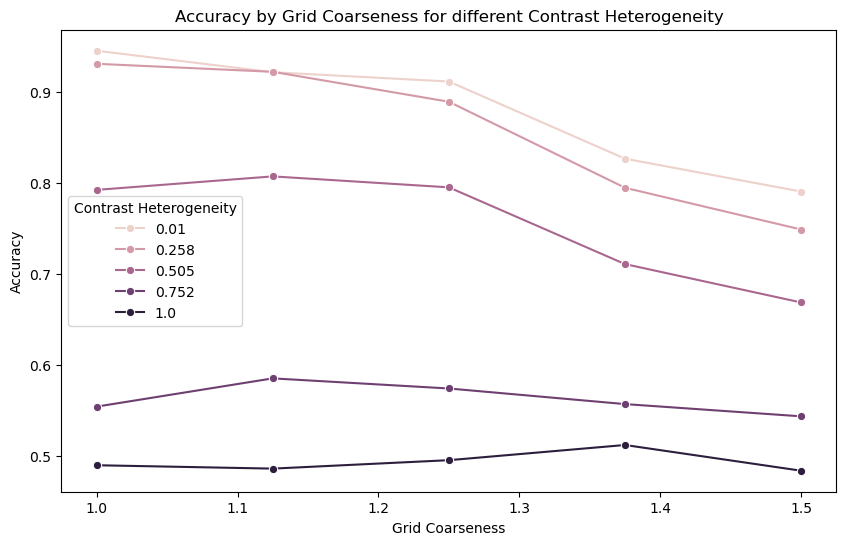

In [31]:
# Take the data from the “ContrastHeterogeneity” and “GridCoarseness” columns, making combinations and measure the mean of the “Correct” column based on the combinations of these variables. 
accuracy_by_grid_and_contrast = data.groupby(['GridCoarseness', 'ContrastHeterogeneity']).mean(['Correct']).reset_index()

# Plotting. 
plt.figure(figsize=(10, 6))
sns.lineplot(x='GridCoarseness', y='Correct', hue='ContrastHeterogeneity', marker='o', data=accuracy_by_grid_and_contrast)
plt.title('Accuracy by Grid Coarseness for different Contrast Heterogeneity')
plt.xlabel('Grid Coarseness')
plt.ylabel('Accuracy')
plt.legend(title='Contrast Heterogeneity')
plt.show()

# Random Forest.
Random Forest algorithm performing the binary classification without any cross-validation, predicting the "Correct" column using "ContrastHeterogeneity" and "GridCoarseness" as the features selection. 

In [41]:
# Data frame with the feature selection.  
X = data[['ContrastHeterogeneity', 'GridCoarseness']]
# Define the target variable “y”, that contains the binary values. 
y = data['Correct']

# Split the data set into training (80%) and test (20%), stratify the “y” data set to balance the data from the “y_train”.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

# Train the Random Forest classifier with the number of decision trees are 100 (n_estimators = 100). 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Performing the predictions. 
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy to compare the predictions with the true values. 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest Classifier: {accuracy * 100:.2f}%")

Accuracy of the Random Forest Classifier: 71.77%


Calculate the F1 score and the Matthew Correlation Coefficient, in order to evaluate the performance of the model. 

In [42]:
# F1 Score Calculation. 
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Matthews Correlation Coefficient (MMC). 
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

F1 Score: 0.82
Matthews Correlation Coefficient (MCC): 0.23


**Confusion Matrix**, present the performance of the model providing a comparison between actual vs. predicted values for each class. 


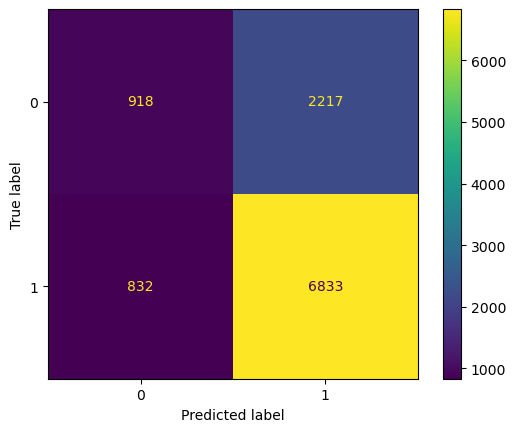

In [43]:
# Comparison between “y_pred” and “y_test”. 
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=rf_classifier.classes_)

# Plotting. 
cmd.plot()
plt.show()

**Feature importance plot**, present the importance of each feature at the moment to make the predictions by the Random Forest Classifier. 


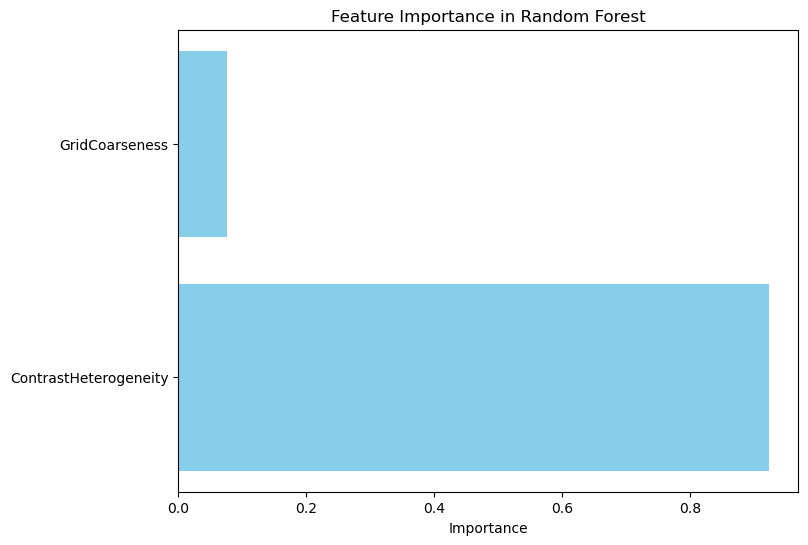

In [44]:
# Extract the feature importance from the trained model. 
importances = rf_classifier.feature_importances_
features = X.columns

# Plotting. 
plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

**ROC curve**, presents the ability of the model to distinguish between positive and negative classes (True Positive Rate “TPR” and False Positive Rate “FPR”), the Area Under the Curve (AUC) qualifies the general performance of the model. 

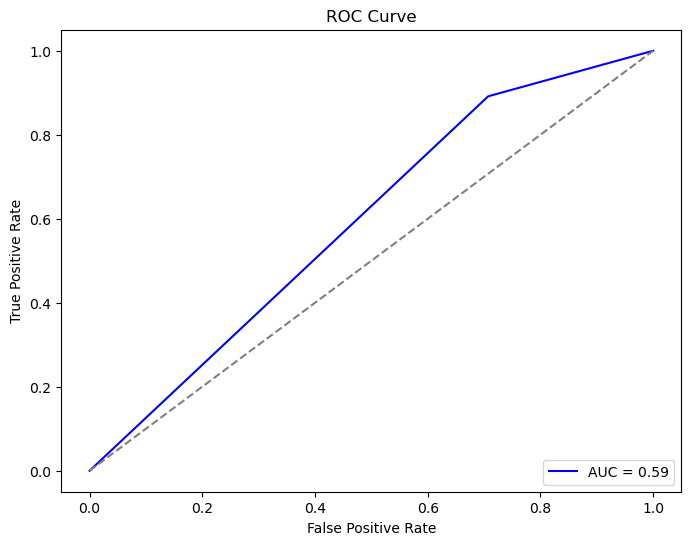

In [45]:
# Predict probabilities of each class. 
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR and the AUC. 
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting. 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Precision-recall curve**, evaluate the performance of the model using the positive classes of the imbalance classes. Average Precision (AP).


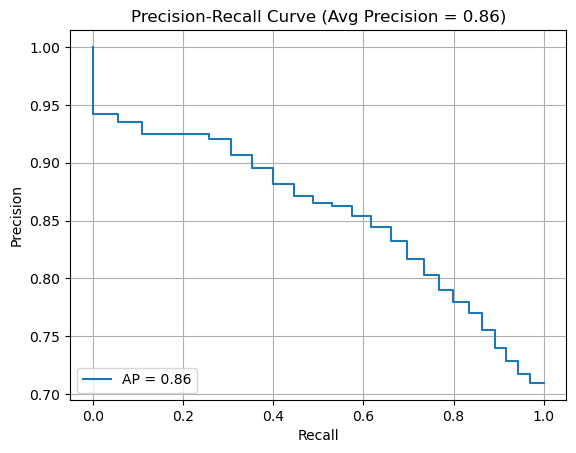

In [46]:
# Predict probabilities. 
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate the precision and recall. 
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Calculate the AP. 
avg_precision = average_precision_score(y_test, y_prob)

# Plotting. 
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
disp.plot()
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Support Vector Machine (SVM).
SVM algorithm performing the binary classification without any cross-validation, predicting the "Correct" column using "ContrastHeterogeneity" and "GridCoarseness" as the features selection. 

In [50]:
# Data frame with the feature selection. 
X = data[['ContrastHeterogeneity', 'GridCoarseness']]
# Define the target variable “y”, that contains the binary values. 
y = data['Correct']

# Split the data set into training (80%) and test (20%), stratify the “y” data set to balance the data from the “y_train”.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

# Train the SVM classifier. 
svm_classifier = SVC(probability=True, kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)

# Performing the predictions. 
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy to compare the predictions with the true values. 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM Classifier: {accuracy * 100:2f}%")

Accuracy of the SVM Classifier: 71.185185%


Calculate the F1 score and the Matthew Correlation Coefficient, in order to evaluate the performance of the model. 

In [51]:
# F1 Score Calculation. 
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Matthews Correlation Coefficient (MMC).
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

F1 Score: 0.82
Matthews Correlation Coefficient (MCC): 0.18


**Confusion Matrix**, present the performance of the model providing a comparison between actual vs. predicted values for each class. 

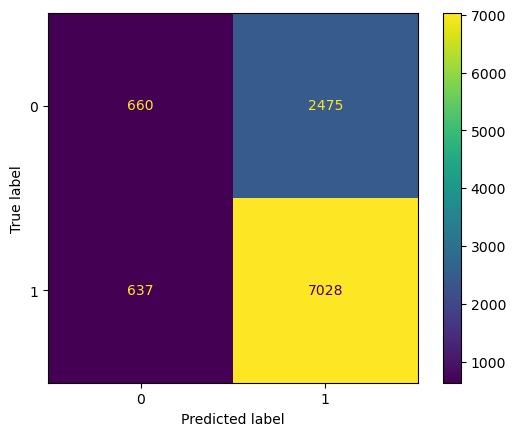

In [52]:
# Comparison between “y_pred” and “y_test”.
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=svm_classifier.classes_)

# Plotting. 
cmd.plot()
plt.show()

**ROC curve**, presents the ability of the model to distinguish between positive and negative classes (True Positive Rate “TPR” and False Positive Rate “FPR”), the Area Under the Curve (AUC) qualifies the general performance of the model. 

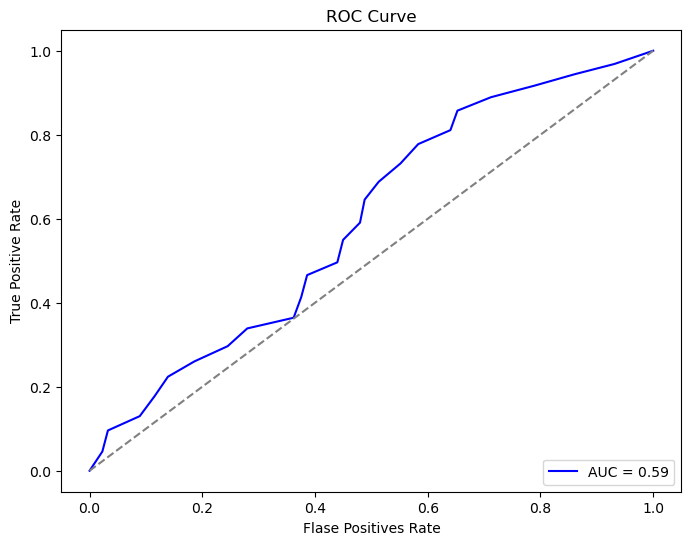

In [53]:
# Predict probabilities of each class. 
y_prob = svm_classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR and the AUC. 
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting. 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Flase Positives Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Precision-recall curve**, evaluate the performance of the model using the positive classes of the imbalance classes. Average Precision (AP).

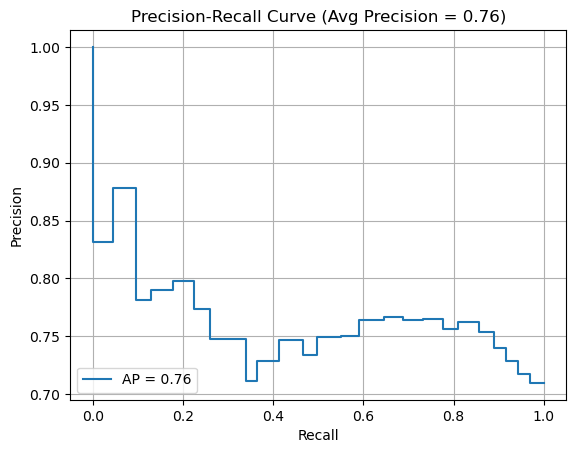

In [54]:
# Predict probabilities. 
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Calculate the AP. 
avg_precision = average_precision_score(y_test, y_prob)

# Plotting. 
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
disp.plot()
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# XGBoost
XGBoost algorithm performing the binary classification without any cross-validation, predicting the "Correct" column using "ContrastHeterogeneity" and "GridCoarseness" as the features selection. 

In [55]:
# Data frame with the feature selection. 
X = data[['ContrastHeterogeneity', 'GridCoarseness']]

# Define the target variable “y”, that contains the binary values. 
y = data['Correct']

# Split the data set into training (80%) and test (20%), stratify the “y” data set to balance the data from the “y_train”.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

# Train the XGBoost classifier. 
xgb_classifier = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Performing the predictions. 
y_pred = xgb_classifier.predict(X_test)

# Calculate the accuracy to compare the predictions with the true values. 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the XGBoost Classifier: {accuracy * 100:.2f}%")

/Users/rodrigosanchez/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:18:25] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of the XGBoost Classifier: 71.77%


Calculate the F1 score and the Matthew Correlation Coefficient, in order to evaluate the performance of the model. 

In [56]:
# F1 Score Calculation. 
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Matthews Correlation Coefficient (MMC).
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

F1 Score: 0.82
Matthews Correlation Coefficient (MCC): 0.23


**Confusion Matrix**, present the performance of the model providing a comparison between actual vs. predicted values for each class. 

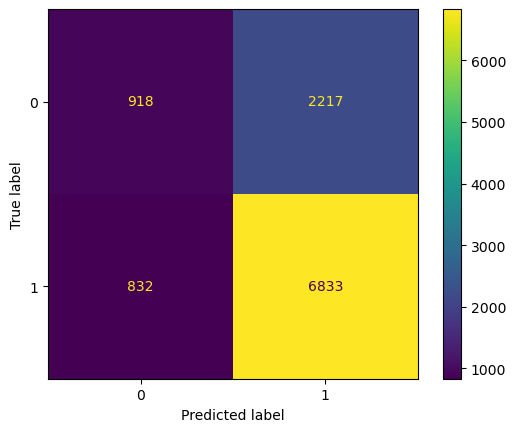

In [57]:
# Comparison between “y_pred” and “y_test”.
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=xgb_classifier.classes_)

# Plotting.
cmd.plot()
plt.show()

**ROC curve**, presents the ability of the model to distinguish between positive and negative classes (True Positive Rate “TPR” and False Positive Rate “FPR”), the Area Under the Curve (AUC) qualifies the general performance of the model. 

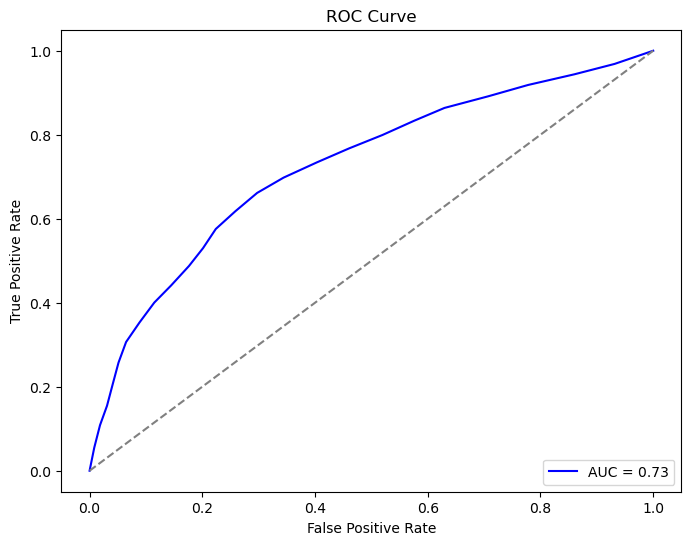

In [59]:
# Predict probabilities of each class. 
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR and the AUC. 
fpr, tpr, _ =roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting. 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Precision-recall curve**, evaluate the performance of the model using the positive classes of the imbalance classes. Average Precision (AP).

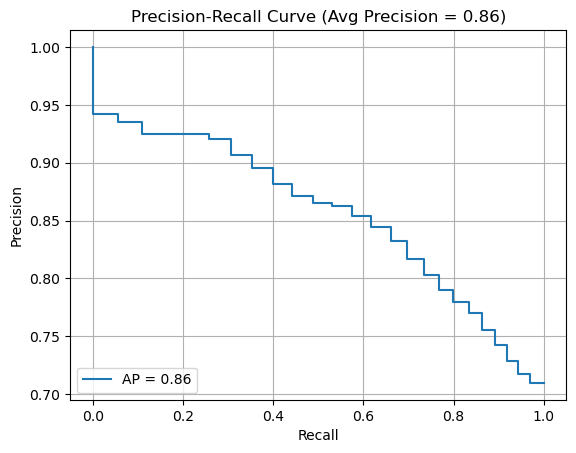

In [61]:
# Predict probabilities. 
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Calculate the AP. 
avg_precision = average_precision_score(y_test, y_prob)

# Plotting. 
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
disp.plot()
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Random Foster with Cross-Validation (Hyperparameters). 
Random Forest algorithm performing the binary classification with a 5-fold cross-validation, predicting the "Correct" column using "ContrastHeterogeneity" and "GridCoarseness" as the features selection. 


In [62]:
# Data frame with the feature selection.   
X = data[['ContrastHeterogeneity', 'GridCoarseness']]

# Define the target variable “y”, that contains the binary values.
y = data['Correct']

# Split the data set into training (80%) and test (20%), stratify the “y” data set to balance the data from the “y_train”.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Hyperparameters with Cross-Validation. 
# Define the parameters that we want to apply. 
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Establish the Random Forest Classifier. 
rf_classifier = RandomForestClassifier(random_state=42)

# Set the GridSearchCV to perform a search over the hyperparameters, using a 5 fold for the cross-validation. 
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the train data set.  
grid_search.fit(X_train, y_train)

# Find the best hyperparameters. 
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the Random Forest using the best hyperparameters. 
best_rf_classifier = grid_search.best_estimator_

# Performing the predictions. 
y_pred = best_rf_classifier.predict(X_test)

# Calculate the accuracy to compare the predictions with the true values. 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest Classifier: {accuracy * 100:.2f}%")

Calculate the F1 score and the Matthew Correlation Coefficient, in order to evaluate the performance of the model. 

In [65]:
# F1 Score Calculation.
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Matthews Correlation Coefficient (MMC).
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

F1 Score: 0.82
Matthews Correlation Coefficient (MCC): 0.19


**Confusion Matrix**, present the performance of the model providing a comparison between actual vs. predicted values for each class. 

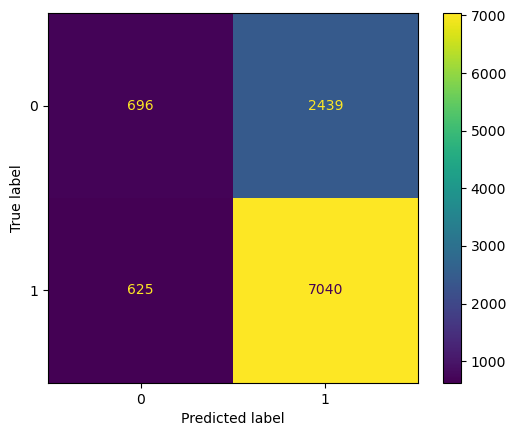

In [66]:
# Comparison between “y_pred” and “y_test”.
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=best_rf_classifier.classes_)

# Plotting.
cmd.plot()
plt.show()

**Feature importance plot**, present the importance of each feature at the moment to make the predictions by the Random Forest Classifier. 

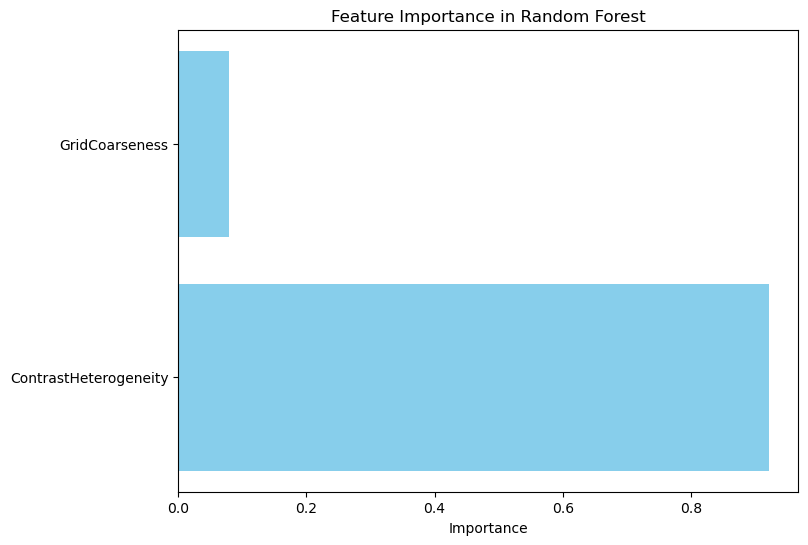

In [67]:
# Extract the feature importance from the trained model. 
importances = best_rf_classifier.feature_importances_
features = X.columns

# Plotting. 
plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

**ROC curve**, presents the ability of the model to distinguish between positive and negative classes (True Positive Rate “TPR” and False Positive Rate “FPR”), the Area Under the Curve (AUC) qualifies the general performance of the model. 

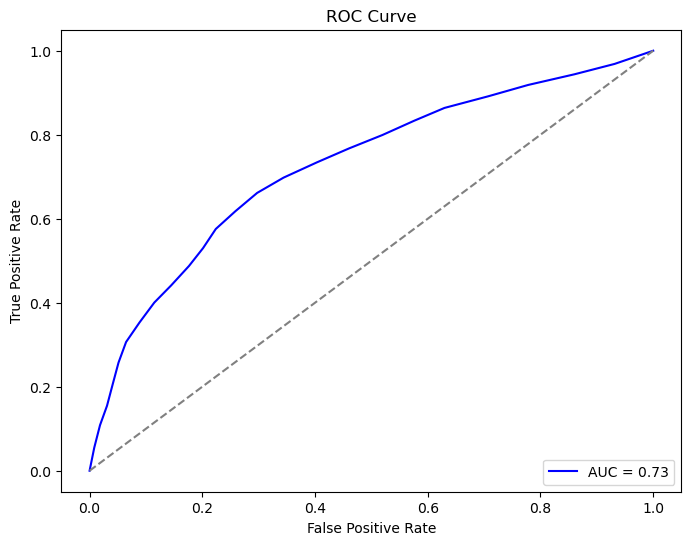

In [68]:
# Predict probabilities of each class. 
y_prob = best_rf_classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR and the AUC. 
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting. 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Precision-recall curve**, evaluate the performance of the model using the positive classes of the imbalance classes. Average Precision (AP).

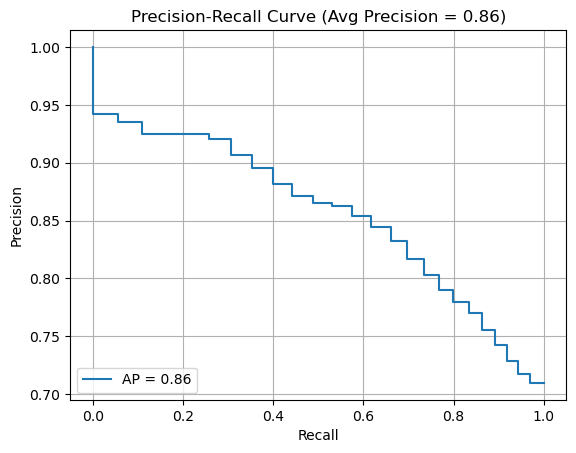

In [69]:
# Calculate the precision and recall. 
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Calculate the AP. 
avg_precision = average_precision_score(y_test, y_prob)

# Plotting. 
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
disp.plot()
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Support Vector Machine (SVM) with Cross-Validation (Hyperparameters). 
SVM algorithm performing the binary classification with a 5-fold cross-validation, predicting the "Correct" column using "ContrastHeterogeneity" and "GridCoarseness" as the features selection. Warning, it takes around 3 hours to perform this model. 

In [3]:
# Data frame with the feature selection. 
X = data[['ContrastHeterogeneity', 'GridCoarseness']]

# Define the target variable “y”, that contains the binary values. 
y = data['Correct']

# Split the data set into training (80%) and test (20%), stratify the “y” data set to balance the data from the “y_train”. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Hyperparameters with Cross-Validation. 
# Define the parameters that we want to apply. 
param_grid = {
    'C': np.logspace(-2, 2, 5),  
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'linear']  
}

# Establish the SVM Classifier. 
svm_classifier = SVC(probability=True, random_state=42)

# Set the RandomizedSearchCV to perform a search over the hyperparameters, using a 5 fold for the cross-validation. 
random_search = RandomizedSearchCV(estimator=svm_classifier, param_distributions=param_grid, 
                                   n_iter=10, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42) # This function helps to optimize the search for the best parameters in the SVM model. 

# Fit the train data set. 
random_search.fit(X_train, y_train)

# Find the best hyperparameters. 
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the SVM using the best hyperparameters. 
best_svm_classifier = random_search.best_estimator_

# Performing the predictions. 
y_pred = best_svm_classifier.predict(X_test)

# Calculate the accuracy to compare the predictions with the true values. 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM Classifier: {accuracy * 100:.2f}%")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time= 4.5min
[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time= 4.5min
[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time= 4.5min
[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time= 7.2min
[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time= 7.2min
[CV] END ..................C=10.0, gamma=0.01, kernel=linear; total time= 5.0min
[CV] END ..................C=10.0, gamma=0.01, kernel=linear; total time= 6.1min
[CV] END ..................C=10.0, gamma=0.01, kernel=linear; total time= 4.4min
[CV] END ..................C=10.0, gamma=0.01, kernel=linear; total time=16.6min
[CV] END ..................C=10.0, gamma=0.01, kernel=linear; total time= 4.3min
[CV] END ...................C=1.0, gamma=0.01, kernel=linear; total time= 3.6min
[CV] END ...................C=1.0, gamma=0.01, k

Calculate the F1 score and the Matthew Correlation Coefficient, in order to evaluate the performance of the model. 

In [11]:
# F1 Score Calculation.
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Matthews Correlation Coefficient (MMC).
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

Accuracy of the SVM Classifier: 71.02%
F1 Score: 0.82
Matthews Correlation Coefficient (MCC): 0.14


**Confusion Matrix**, present the performance of the model providing a comparison between actual vs. predicted values for each class. 

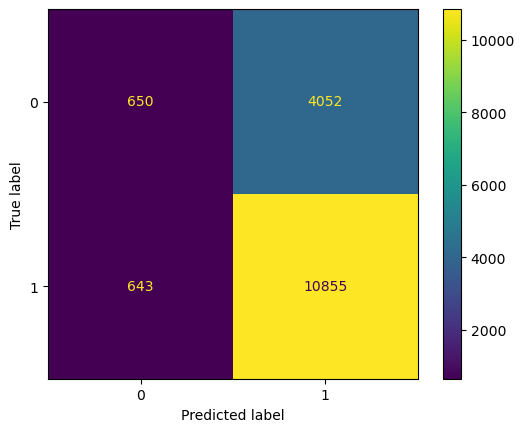

In [12]:
# Comparison between “y_pred” and “y_test”.
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=best_svm_classifier.classes_)

# Plotting.
cmd.plot()
plt.show()

**ROC curve**, presents the ability of the model to distinguish between positive and negative classes (True Positive Rate “TPR” and False Positive Rate “FPR”), the Area Under the Curve (AUC) qualifies the general performance of the model. 

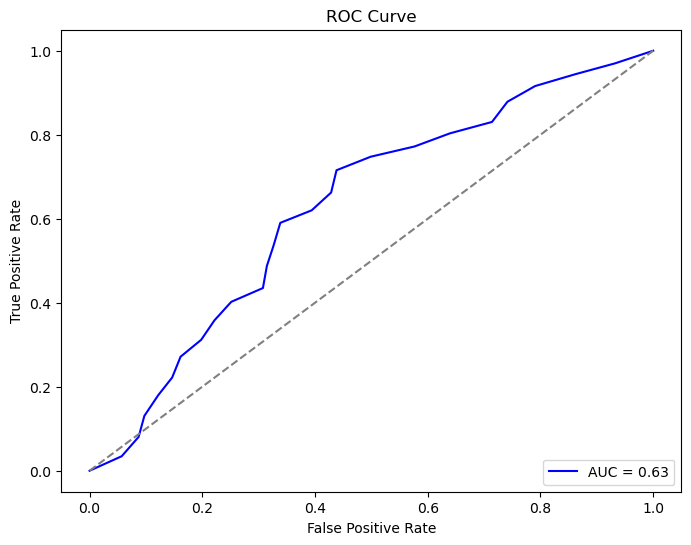

In [13]:
# Predict probabilities of each class. 
y_prob = best_svm_classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR and the AUC. 
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting. 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Precision-recall curve**, evaluate the performance of the model using the positive classes of the imbalance classes. Average Precision (AP).

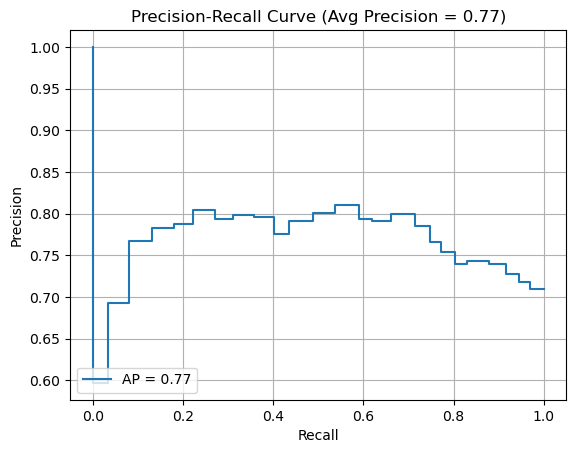

In [14]:
# Calculate the precision and recall. 
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Calculate the AP. 
avg_precision = average_precision_score(y_test, y_prob)

# Plotting. 
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
disp.plot()
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# XGBoost with Cross-Validation (Hyperparameters). 
XGBoost algorithm performing the binary classification with a 5-fold cross-validation, predicting the "Correct" column using "ContrastHeterogeneity" and "GridCoarseness" as the features selection.

In [72]:
# Data frame with the feature selection. 
X = data[['ContrastHeterogeneity', 'GridCoarseness']]

# Define the target variable “y”, that contains the binary values.  
y = data['Correct']

# Split the data set into training (80%) and test (20%), stratify the “y” data set to balance the data from the “y_train”. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Hyperparameters with Cross-Validation. 
# Establish the XGBoost Classifier. 
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameters that we want to apply. 
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set the GridSearchCV to perform a search over the hyperparameters, using a 5 fold for the cross-validation. 
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the train data set.  
grid_search.fit(X_train, y_train)

# Find the best hyperparameters. 
print(f"Best parameters found: {grid_search.best_params_}")

# Train the XGBoost using the best hyperparameters. 
best_xgb_classifier = grid_search.best_estimator_

# Performing the predictions. 
y_pred = best_xgb_classifier.predict(X_test)

# Calculate the accuracy to compare the predictions with the true values. 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the XGBoost Classifier: {accuracy * 100:.2f}%")

Calculate the F1 score and the Matthew Correlation Coefficient, in order to evaluate the performance of the model. 

In [74]:
# F1 Score Calculation.
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Matthews Correlation Coefficient (MMC).
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

F1 Score: 0.82
Matthews Correlation Coefficient (MCC): 0.14


**Confusion Matrix**, present the performance of the model providing a comparison between actual vs. predicted values for each class. 

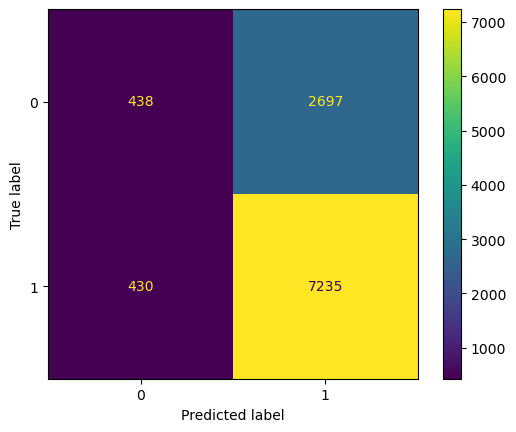

In [75]:
# Comparison between “y_pred” and “y_test”.
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=best_xgb_classifier.classes_)

# Plotting.
cmd.plot()
plt.show()

**ROC curve**, presents the ability of the model to distinguish between positive and negative classes (True Positive Rate “TPR” and False Positive Rate “FPR”), the Area Under the Curve (AUC) qualifies the general performance of the model. 

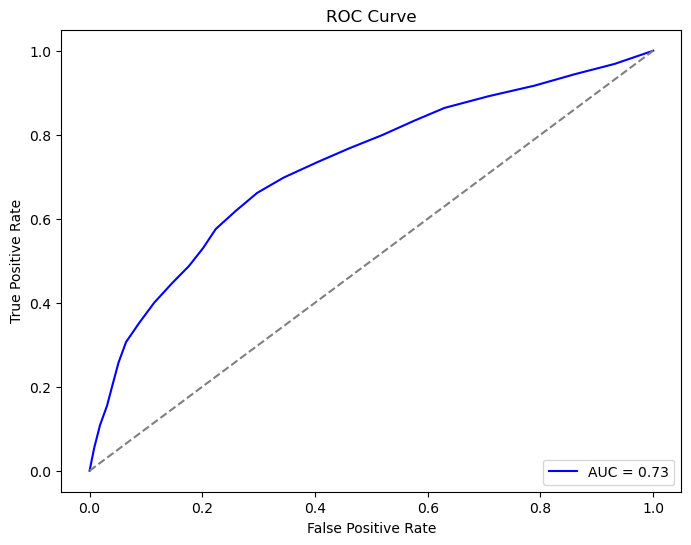

In [76]:
# Predict probabilities of each class. 
y_prob = best_xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR and the AUC. 
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting. 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Precision-recall curve**, evaluate the performance of the model using the positive classes of the imbalance classes. Average Precision (AP).

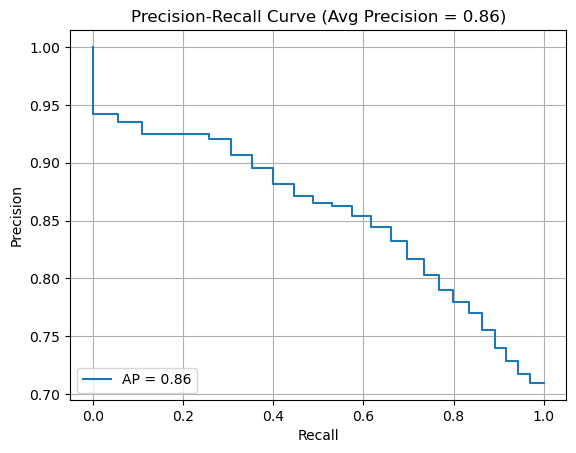

In [77]:
# Calculate the precision and recall. 
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Calculate the AP. 
avg_precision = average_precision_score(y_test, y_prob)

# Plotting. 
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
disp.plot()
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Conclusions
- Hyperparameters improve the performance of Random Foster and SVM. 
- The XGBoost had the same measure in AUC and F1 score after the cross-validation hyperparameters. 
- Random Forest and XGBoost had the best performance with this binary data set. 
- SVM had the lowest performance. 
- In the case of the MCC measure decrease in the tree models after the cross-validation hyperparameters. The cross-validation may be producing a type of bias with the minimal classes. 